# TF2, RBM 으로 MNIST 데이터 생성

In [1]:
import tensorflow as tf
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    # 텐서플로가 첫 번째 GPU만 사용하도록 제한
    # 프로그램 시작시에 메모리 증가가 설정되어야만 합니다
    try:
        tf.config.experimental.set_visible_devices(gpus[0], 'GPU')
        tf.config.experimental.set_memory_growth(gpus[0], True)
        print('GPU[0] is ready')
    except RuntimeError as e:
        # 프로그램 시작시에 접근 가능한 장치가 설정되어야만 합니다
        print(e)
else:
    print('Please check GPU available')
    
import os
import sys
import tensorflow as tf
from tensorflow.keras import datasets, layers, models, optimizers
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import clear_output
from six.moves import urllib
from tensorflow import feature_column as fc
import tensorflow_datasets as tfds
plt.rcParams["font.family"] = 'NanumBarunGothic'
TENSORBOARD_BINARY = '/home/hoondori/anaconda3/envs/ai/bin/tensorboard'
os.environ['TENSORBOARD_BINARY'] =  TENSORBOARD_BINARY 

Please check GPU available


In [2]:
import tensorflow as tf
import numpy as np
from matplotlib import pyplot as plt
import tensorflow.keras as K

# 데이터 확보 

In [16]:
(x_train, _), (x_test, _) = K.datasets.mnist.load_data()

x_train = x_train.astype(np.float32)
x_test = x_test.astype(np.float32)

x_train = x_train / 255.
x_test = x_test / 255.

x_train = np.reshape(x_train, (x_train.shape[0], 784))
x_test = np.reshape(x_test, (x_test.shape[0], 784))

print(x_train.shape, x_test.shape)

(60000, 784) (10000, 784)


# 모델 

In [12]:
#Class that defines the behavior of the RBM
class RBM(object):
    
    def __init__(self, input_size, output_size, lr=1.0, batchsize=100):
        """
        m: Number of neurons in visible layer
        n: number of neurons in hidden layer
        """
        #Defining the hyperparameters
        self._input_size = input_size #Size of Visible
        self._output_size = output_size #Size of outp
        self.learning_rate = lr #The step used in gradient descent
        self.batchsize = batchsize #The size of how much data will be used for training per sub iteration
        
        #Initializing weights and biases as matrices full of zeroes
        self.w = tf.zeros([input_size, output_size], np.float32) #Creates and initializes the weights with 0
        self.hb = tf.zeros([output_size], np.float32) #Creates and initializes the hidden biases with 0
        self.vb = tf.zeros([input_size], np.float32) #Creates and initializes the visible biases with 0


    #Forward Pass
    def prob_h_given_v(self, visible, w, hb):
        #Sigmoid 
        return tf.nn.sigmoid(tf.matmul(visible, w) + hb)

    #Backward Pass
    def prob_v_given_h(self, hidden, w, vb):
        return tf.nn.sigmoid(tf.matmul(hidden, tf.transpose(w)) + vb)
    
    #Generate the sample probability
    def sample_prob(self, probs):
        return tf.nn.relu(tf.sign(probs - tf.random.uniform(tf.shape(probs))))

    #Training method for the model
    def train(self, X, epochs=10):
               
        loss = []
        for epoch in range(epochs):
            #For each step/batch
            for start, end in zip(range(0, len(X), self.batchsize),range(self.batchsize,len(X), self.batchsize)):
                batch = X[start:end]
                    
                #Initialize with sample probabilities
                    
                h0 = self.sample_prob(self.prob_h_given_v(batch, self.w, self.hb))
                v1 = self.sample_prob(self.prob_v_given_h(h0, self.w, self.vb))
                h1 = self.prob_h_given_v(v1, self.w, self.hb)
                    
                #Create the Gradients
                positive_grad = tf.matmul(tf.transpose(batch), h0)
                negative_grad = tf.matmul(tf.transpose(v1), h1)
                    
                #Update learning rates 
                self.w = self.w + self.learning_rate *(positive_grad - negative_grad) / tf.dtypes.cast(tf.shape(batch)[0],tf.float32)
                self.vb = self.vb +  self.learning_rate * tf.reduce_mean(batch - v1, 0)
                self.hb = self.hb +  self.learning_rate * tf.reduce_mean(h0 - h1, 0)
                    
            #Find the error rate
            err = tf.reduce_mean(tf.square(batch - v1))
            print ('Epoch: %d' % epoch,'reconstruction error: %f' % err)
            loss.append(err)
                    
        return loss
        
    #Create expected output for our DBN
    def rbm_output(self, X):
        out = tf.nn.sigmoid(tf.matmul(X, self.w) + self.hb)
        return out
    
    def rbm_reconstruct(self,X):
        h = tf.nn.sigmoid(tf.matmul(X, self.w) + self.hb)
        reconstruct = tf.nn.sigmoid(tf.matmul(h, tf.transpose(self.w)) + self.vb)
        return reconstruct
            

In [13]:
#Size of inputs is the number of inputs in the training set
input_size = train_data.shape[1]
rbm = RBM(input_size, 200)

err = rbm.train(train_data,50)

Epoch: 0 reconstruction error: 0.056975
Epoch: 1 reconstruction error: 0.051559
Epoch: 2 reconstruction error: 0.048518
Epoch: 3 reconstruction error: 0.048835
Epoch: 4 reconstruction error: 0.047120
Epoch: 5 reconstruction error: 0.047572
Epoch: 6 reconstruction error: 0.046152
Epoch: 7 reconstruction error: 0.045890
Epoch: 8 reconstruction error: 0.046353
Epoch: 9 reconstruction error: 0.044971
Epoch: 10 reconstruction error: 0.045604
Epoch: 11 reconstruction error: 0.044638
Epoch: 12 reconstruction error: 0.043723
Epoch: 13 reconstruction error: 0.043351
Epoch: 14 reconstruction error: 0.043654
Epoch: 15 reconstruction error: 0.041957
Epoch: 16 reconstruction error: 0.043271
Epoch: 17 reconstruction error: 0.042632
Epoch: 18 reconstruction error: 0.042853
Epoch: 19 reconstruction error: 0.041714
Epoch: 20 reconstruction error: 0.042215
Epoch: 21 reconstruction error: 0.042594
Epoch: 22 reconstruction error: 0.041415
Epoch: 23 reconstruction error: 0.043109
Epoch: 24 reconstruction e

Text(0, 0.5, 'cost')

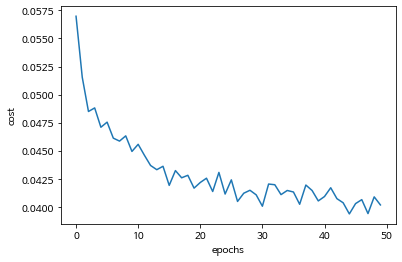

In [14]:
plt.plot(err)
plt.xlabel('epochs')
plt.ylabel('cost')

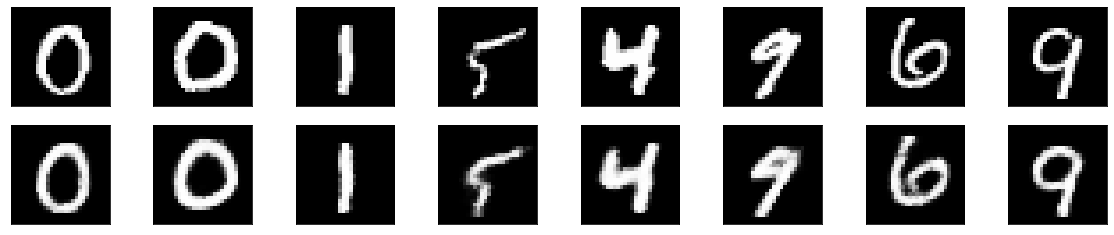

In [15]:
out = rbm.rbm_reconstruct(test_data)

# Plotting original and reconstructed images
row, col = 2, 8
idx = np.random.randint(0, 100, row * col // 2)
f, axarr = plt.subplots(row, col, sharex=True, sharey=True, figsize=(20,4))
for fig, row in zip([test_data,out], axarr):
    for i,ax in zip(idx,row):
        ax.imshow(tf.reshape(fig[i],[28, 28]), cmap='Greys_r')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)